# Сравнение поисковых деревьев
### Выполнили Вихрев И., Репин В. гр 382006-3м

In [28]:
import sys
import os
from pathlib import Path
import numpy as np
import random
import time
import statistics as stat
sys.path.append(str(Path.cwd().resolve()/'python_bindings'))
import trees

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style = 'whitegrid', rc={'figure.figsize':(20, 10)})

In [30]:
dir(trees)

['AVLTreeInt',
 'AVLTreeString',
 'RBTreeInt',
 'RBTreeString',
 'SortedArrInt',
 'SortedArrString',
 'SplayTreeInt',
 'SplayTreeString',
 'TreapInt',
 'TreapString',
 '__builtins__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__test__']

In [31]:
def evaluate(tree, unique_set, count_rot = False):
    total = 0
    insert_time = []
    search_time = []
    delete_time = []
    rotations_count = []
    nelems = len(unique_set)
    # shuffled_set = random.sample(unique_set, len(unique_set))
    # insertion and searching time
    start_total = time.time()
    for idx, n in enumerate(unique_set):
        insert_mean = 0
        delete_mean = 0
        search_mean = 0
        
        tree.insert(n)
        if (idx == 0): continue
        
        # make 5 operations for random element from already added numbers
        for i in range(5):
            # generate random index, delete, then insert
            el = random.randrange(idx, nelems)
            insert_mean += tree.insert(unique_set[el]) / 5
            tree.delete(unique_set[el])
            
            search_mean += tree.search(unique_set[random.randrange(idx)]) / 5
            
            # generate random index, insert, then delete
            el = random.randrange(idx)
            delete_mean += tree.delete(unique_set[el]) / 5
            tree.insert(unique_set[el])
        
        insert_time.append(insert_mean)
        delete_time.append(delete_mean)
        search_time.append(search_mean)     
        
        if(count_rot):
            rotations_count.append(tree.rotations_num)
        
    end_total = time.time()
    total = end_total - start_total
    
    insert_mean = stat.mean(insert_time)
    std_insert = stat.stdev(insert_time)
    
    search_mean = stat.mean(search_time)
    std_search = stat.stdev(search_time)
    
    delete_mean = stat.mean(delete_time)
    std_delete = stat.stdev(delete_time)
    
    print(f'Insert, Mean : {stat.mean(insert_time)*10**(3):.6f} ms.,  Max {max(insert_time)*10**(3):.6f} ms.')
    print(f'Search, Mean : {stat.mean(search_time)*10**(3):.6f} ms.,  Max {max(search_time)*10**(3):.6f} ms.')
    print(f'Delete, Mean : {stat.mean(delete_time)*10**(3):.6f} ms.,  Max {max(delete_time)*10**(3):.6f} ms.')
    
    insert_time = [x if x < insert_mean + 3*std_insert else insert_mean for x in insert_time]
    search_time = [x if x < search_mean + 3*std_search else search_mean for x in search_time]
    delete_time = [x if x < delete_mean + 3*std_delete else delete_mean for x in delete_time]
    
    print(f'Total time {(total):.6f}, sec')
    return (insert_time, search_time, delete_time, rotations_count)

Гененеруем выборку уникальных натуральных чисел:

In [32]:
r = 10**6
unique_num_set = random.sample(range(0, r), r)
num = range(1, len(unique_num_set))

In [64]:
def drawGraphs(time_arr, num, tree_name, op_name):
    # Выбираем контрольные значения для оси X    # 
    d = 10**3
    x = [i*d for i in range(len(unique_num_set)//d)]
    x[-1] += -1
    
    y = [time_arr[el] for el in x]
    plt.title(f"{tree_name} {op_name} time", fontsize=20)
    plt.xlabel('n, elements', fontsize=20)
    plt.ylabel('t, ms', fontsize=20)
    plt.plot(x, y) 
    
    repeat = True
    while repeat:
        try:
            if(tree_name != "Sorted array" or op_name == 'searching'):
                coeff = np.polyfit(np.log2(num), time_arr, 1)
                y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
            else:
                coeff = np.polyfit(num, time_arr, 1)
                y = [n*coeff[0] + coeff[1] for n in num]
            repeat = False
            plt.plot(num, y)  
        except Exception:
            pass
    plt.legend(['raw data', 'fit'], fontsize=20)
    plt.ylim(bottom=0.)
    pass

### Методика: 
Замер времени вставки, поиска и удаления элемента проводился 5 раз для каждого количества элементов дерева. В результат бралось среднее значение 5 измерений для каждой операции на каждой итерации цикла. График зависимости строим по данным для каждого 1000 элемента. Выборка обрабатывается по правилу трех сигм.

* np.polyfit(np.log2(num), *, 1) - неустойчивый метод, может при некоторых запусках не сходиться и потребуется перезапуск

# splay tree

Двоичное дерево поиска, в котором поддерживается свойство сбалансированности. Особенностью является то, что при каждом обращении к дереву вызывается функция splay(x) - перемещение элемента x к корню дерева. Амортизированное время выполнения основных операций(вставка, поиск, удаление) - O(log(n))

In [26]:
sp_insert_time, sp_search_time, sp_delete_time, _ = evaluate(trees.SplayTreeInt(), unique_num_set)

Insert, Mean : 0.001772 ms.,  Max 0.988340 ms.
Search, Mean : 0.001438 ms.,  Max 0.537920 ms.
Delete, Mean : 0.001776 ms.,  Max 3.415680 ms.
Total time 52.701983, sec


### Insertion

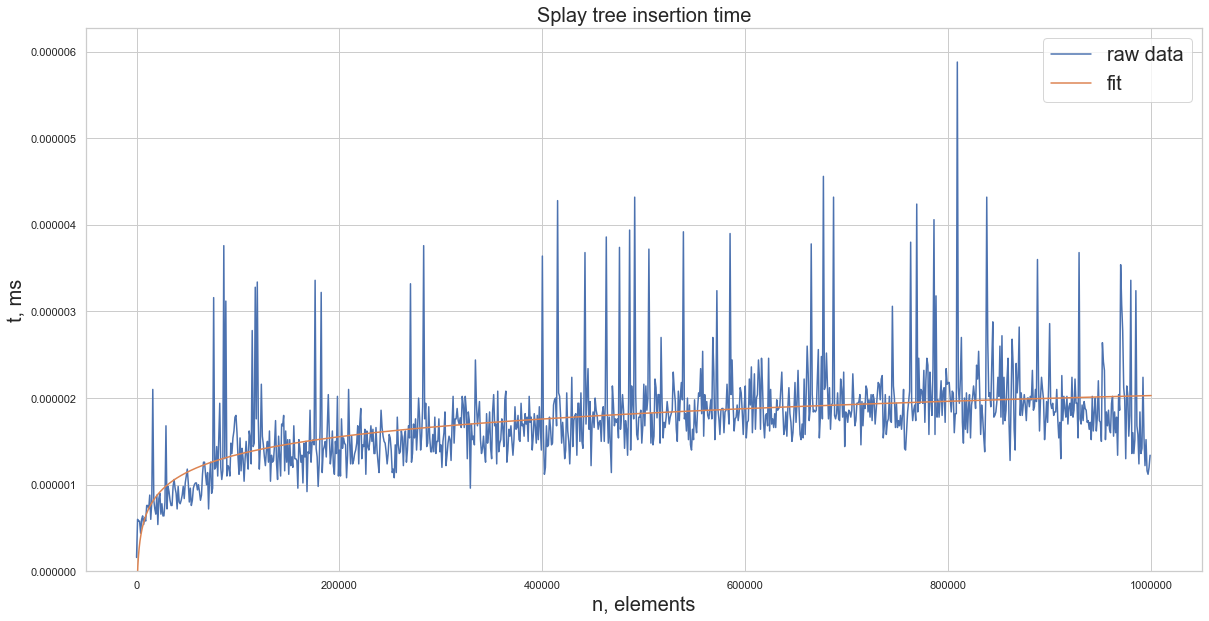

In [34]:
drawGraphs(sp_insert_time, num, "Splay tree", "insertion")

### Searching

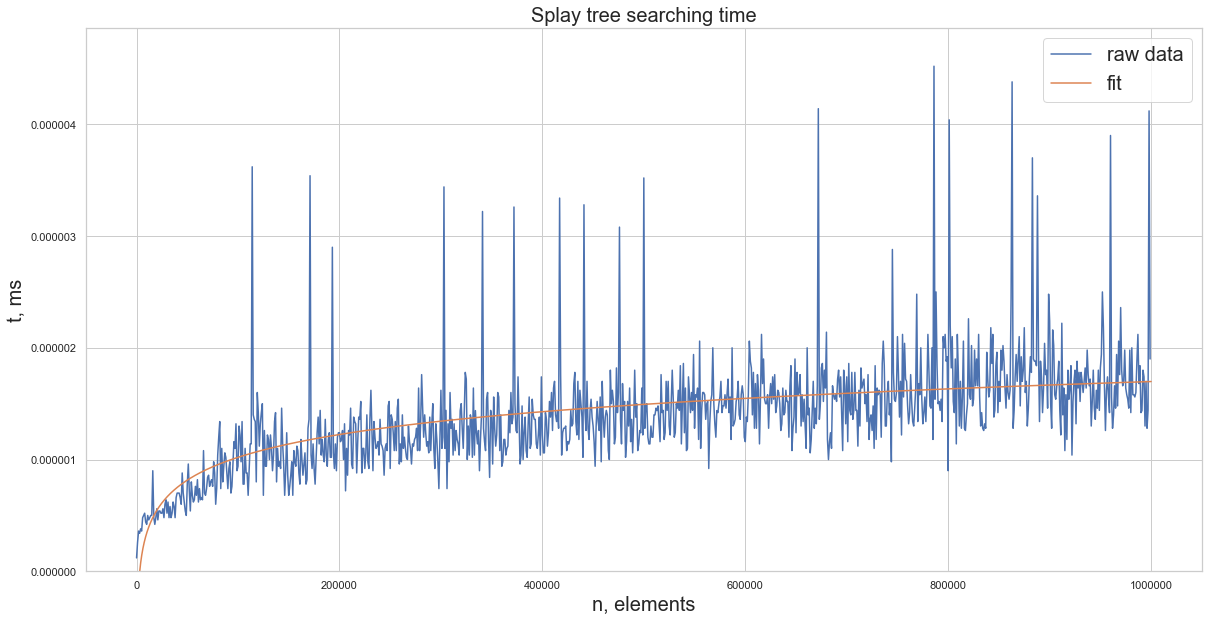

In [65]:
drawGraphs(sp_search_time, num, "Splay tree", "searching")

### Deletion

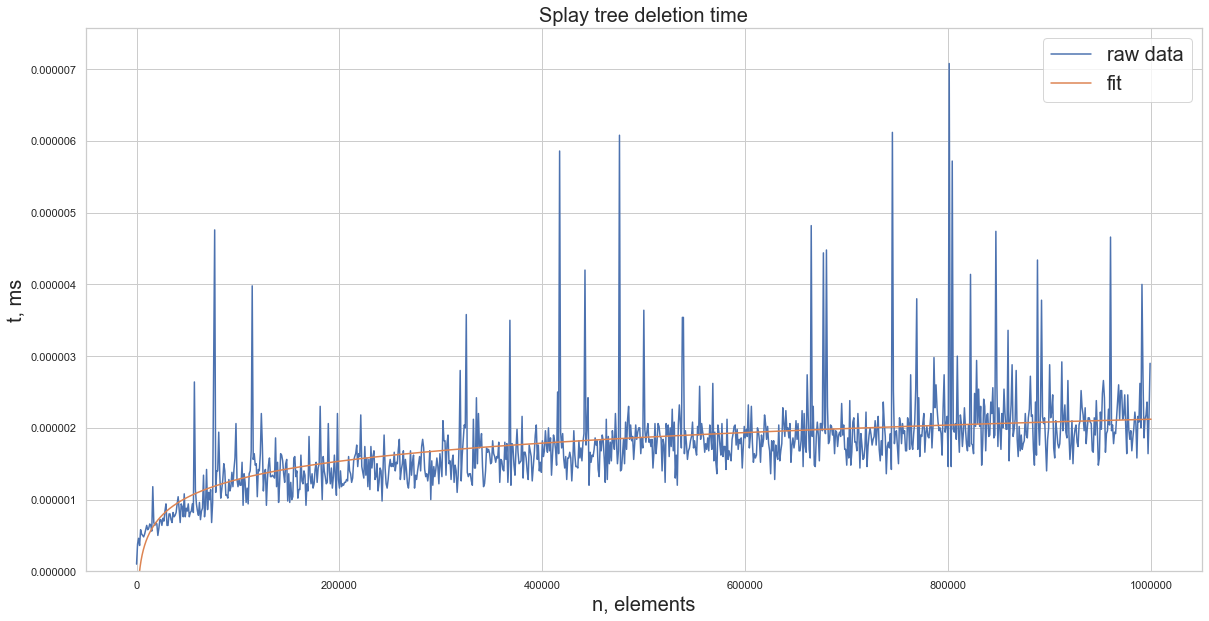

In [42]:
drawGraphs(sp_delete_time, num, "Splay tree", "deletion")

# AVL tree

Сбалансированное двоичное дерево поиска, в котором поддерживается следующее свойство: для каждой его вершины высота её двух поддеревьев различается не более чем на 1. Среднее время выполнения основных операций O(log(n))

In [43]:
avl_insert_time, avl_search_time, avl_delete_time, rotations_count = evaluate(trees.AVLTreeInt(), unique_num_set, True)

Insert, Mean : 0.001912 ms.,  Max 3.101700 ms.
Search, Mean : 0.000930 ms.,  Max 2.181460 ms.
Delete, Mean : 0.001954 ms.,  Max 1.711280 ms.
Total time 57.864013, sec


### Rotations

Количество поворотов при вставке:

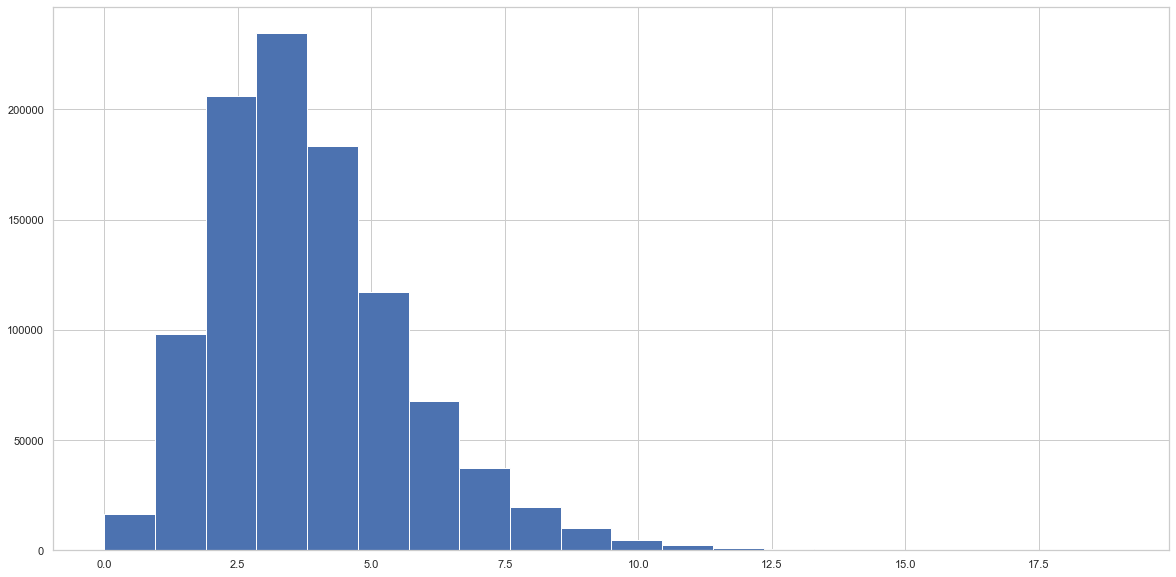

In [44]:
plt.hist(rotations_count, bins = len(set(rotations_count)) )
pass


Максимальное количество поворотов, выполненных при вставке для балансировки дерева:

In [45]:
max(rotations_count)

19

### Insertion

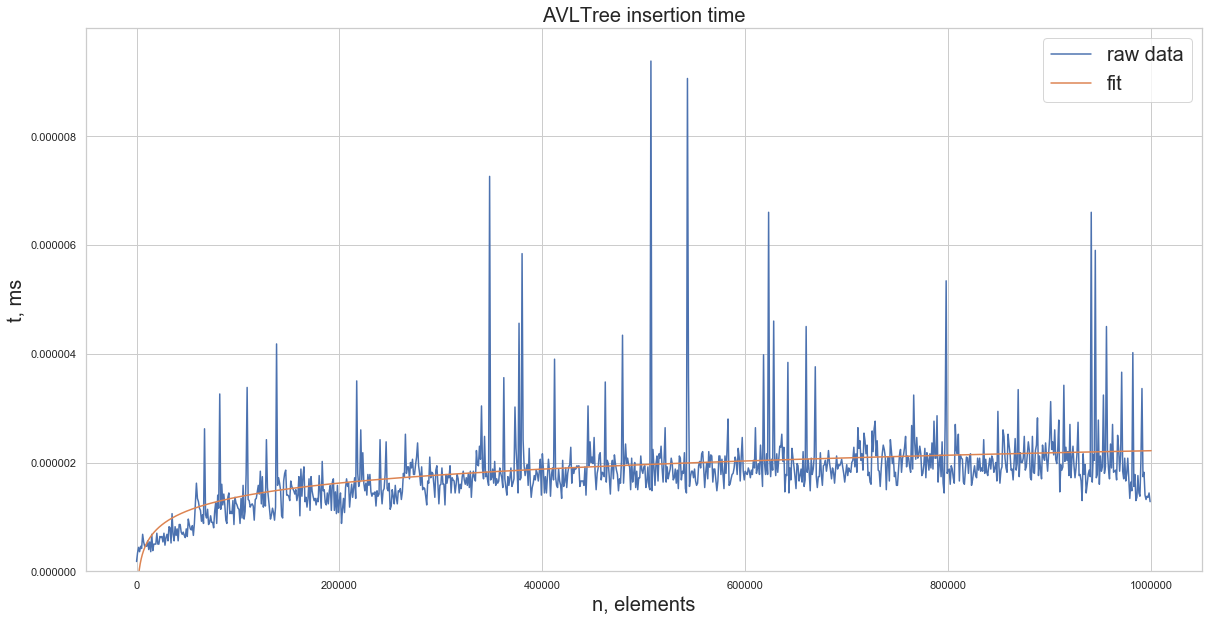

In [46]:
drawGraphs(avl_insert_time, num, "AVLTree", "insertion")

### Searching

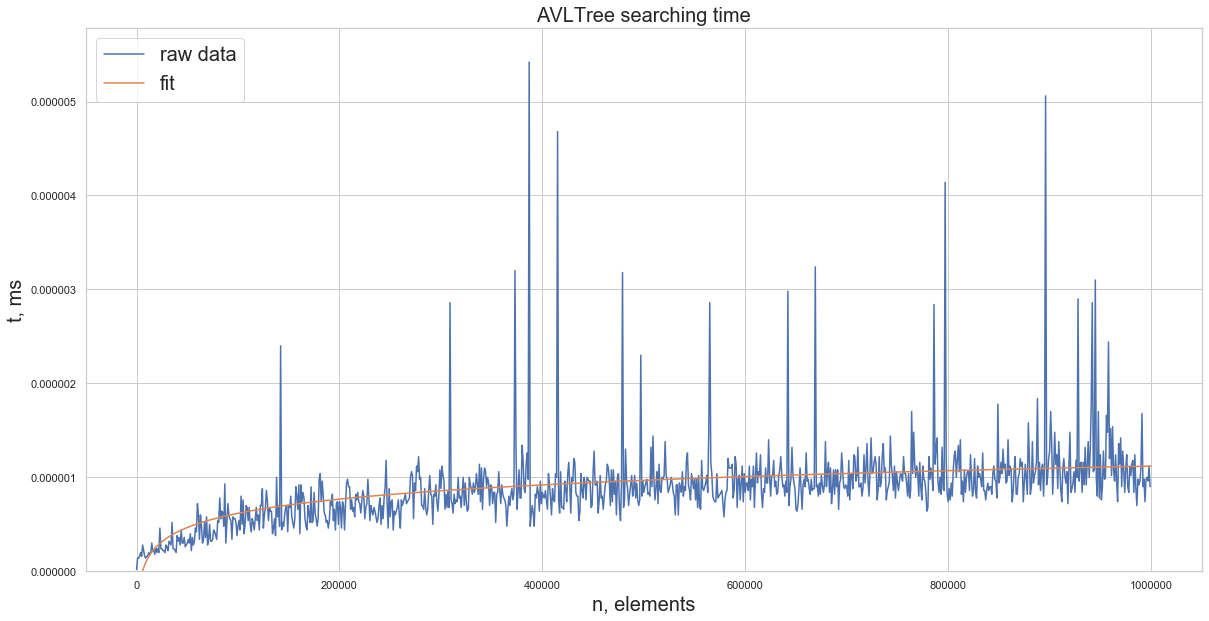

In [47]:
drawGraphs(avl_search_time, num, "AVLTree", "searching")

### Deletion

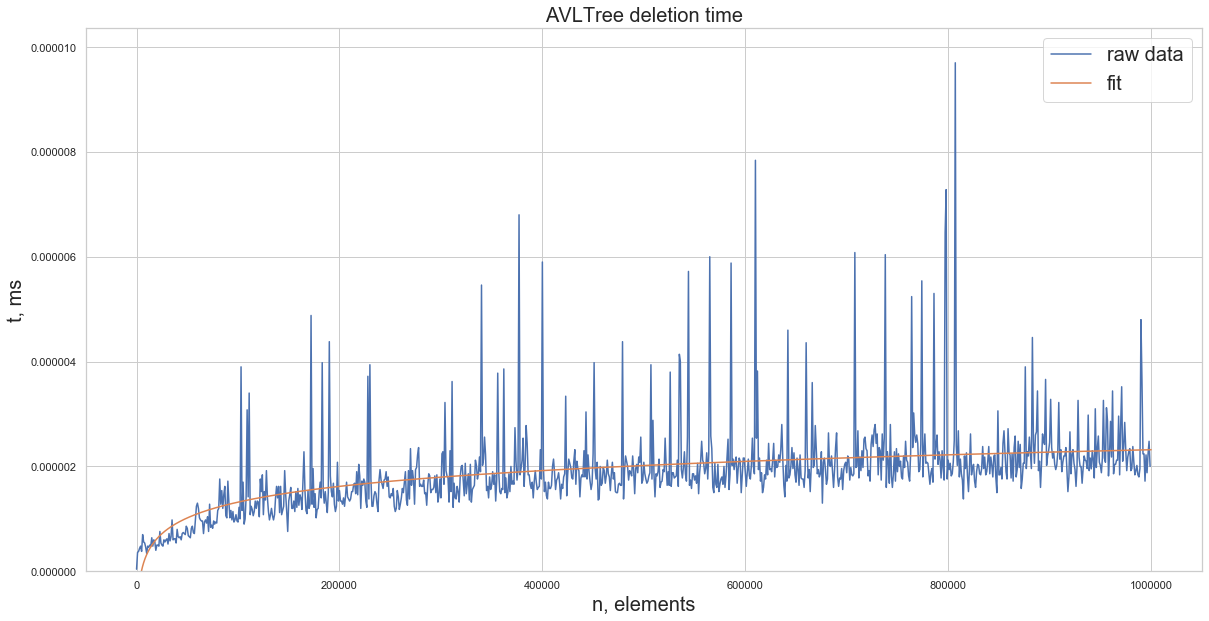

In [48]:
drawGraphs(avl_delete_time, num, "AVLTree", "deletion")

# Treap

Декартово дерево - это структура данных, объединяющая в себе бинарное дерево поиска и бинарную кучу (отсюда и второе её название: treap (tree+heap) и дерамида (дерево+пирамида).

Эта структура данных хранит пары (X,Y) в виде бинарного дерева таким образом, что она является бинарным деревом поиска по x и бинарной пирамидой по y. Предполагая, что все X и все Y являются различными, получаем, что если некоторый элемент дерева содержит (X0,Y0), то у всех элементов в левом поддереве X < X0, у всех элементов в правом поддереве X > X0, а также и в левом, и в правом поддереве имеем: Y < Y0.

Основные операции в среднем выполняются за O(log(n)).

In [49]:
treap_insert_time, treap_search_time, treap_delete_time, _ = evaluate(trees.TreapInt(), unique_num_set)

Insert, Mean : 0.001424 ms.,  Max 6.746300 ms.
Search, Mean : 0.001044 ms.,  Max 1.029800 ms.
Delete, Mean : 0.001383 ms.,  Max 0.482180 ms.
Total time 49.283912, sec


### Insertion

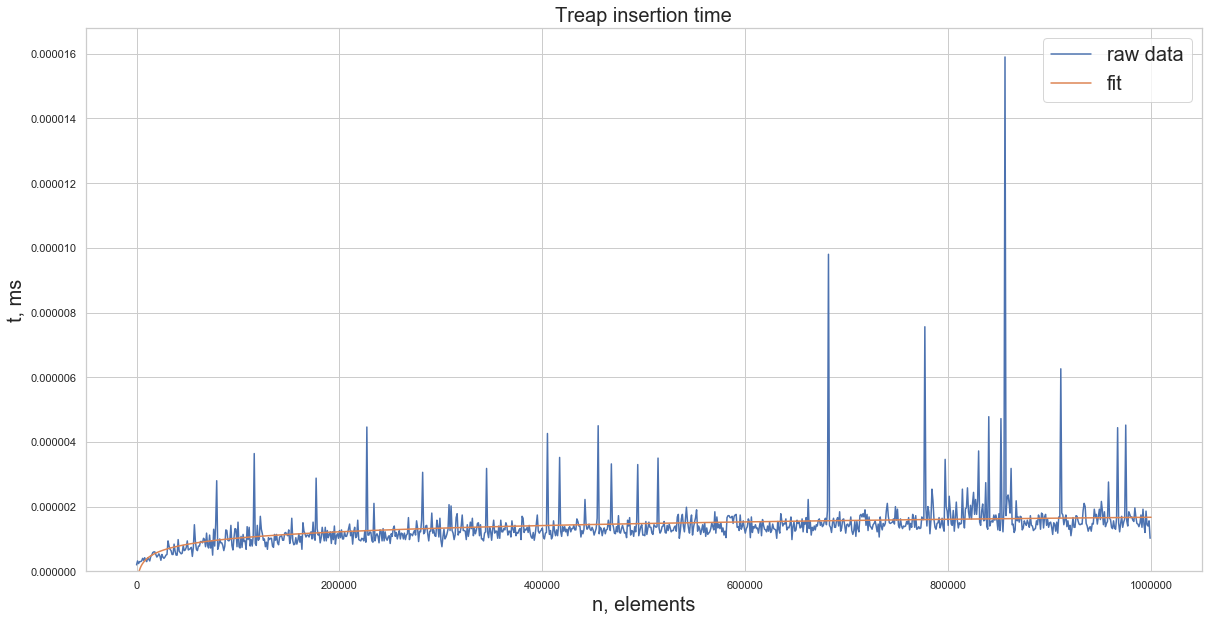

In [50]:
drawGraphs(treap_insert_time, num, "Treap", "insertion")

### Searching

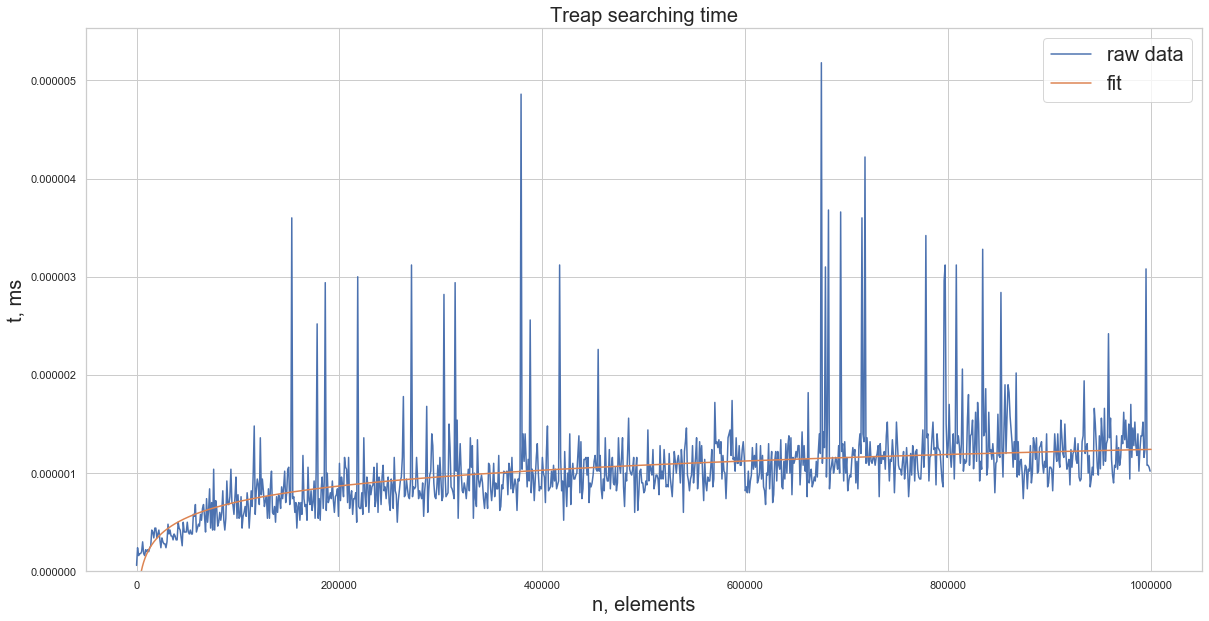

In [51]:
drawGraphs(treap_search_time, num, "Treap", "searching")

### Deletion

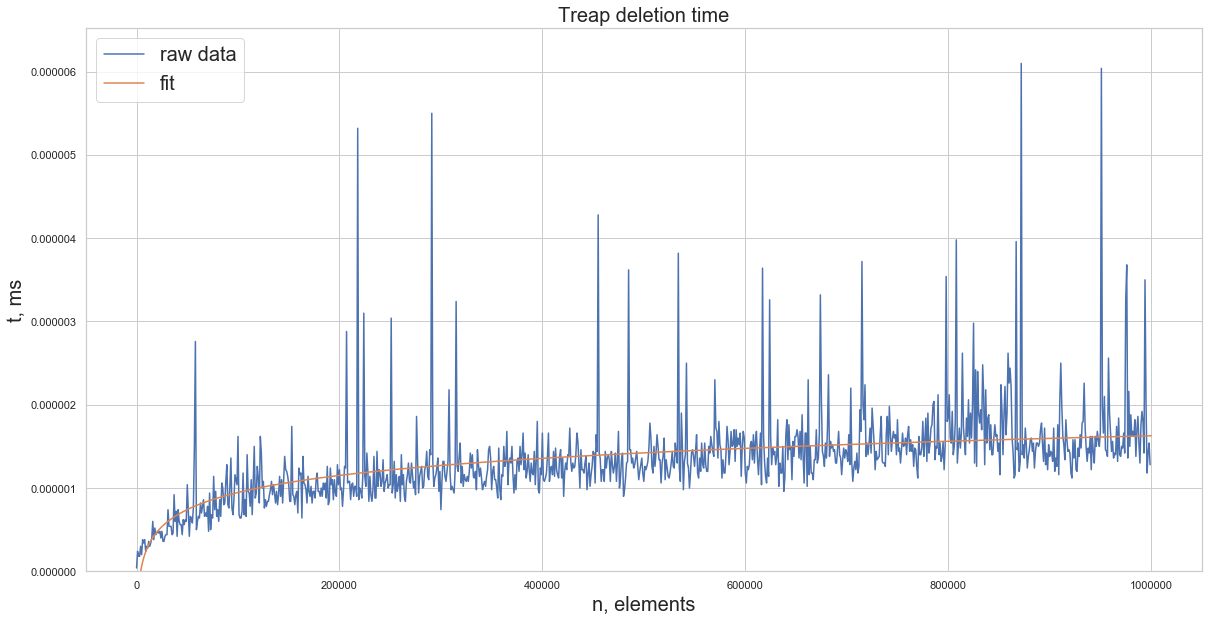

In [52]:
drawGraphs(treap_delete_time, num, "Treap", "deletion")

# Red-Black tree

Один из видов самобалансирующихся двоичных деревьев поиска, гарантирующих логарифмический рост высоты дерева от числа узлов и позволяющее быстро выполнять основные операции дерева поиска: добавление, удаление и поиск узла. Сбалансированность достигается за счёт введения дополнительного атрибута узла дерева — «цвета». Этот атрибут может принимать одно из двух возможных значений — «чёрный» или «красный». 

Для реализации используется std::set<T> из стандартной библиотеки cpp. Основные операции в среднем выполняются за O(log(n)).

In [53]:
rb_insert_time, rb_search_time, rb_delete_time, _ = evaluate(trees.RBTreeInt(), unique_num_set)

Insert, Mean : 0.001026 ms.,  Max 1.495220 ms.
Search, Mean : 0.000927 ms.,  Max 7.624100 ms.
Delete, Mean : 0.001339 ms.,  Max 0.335060 ms.
Total time 44.003998, sec


### Insertion

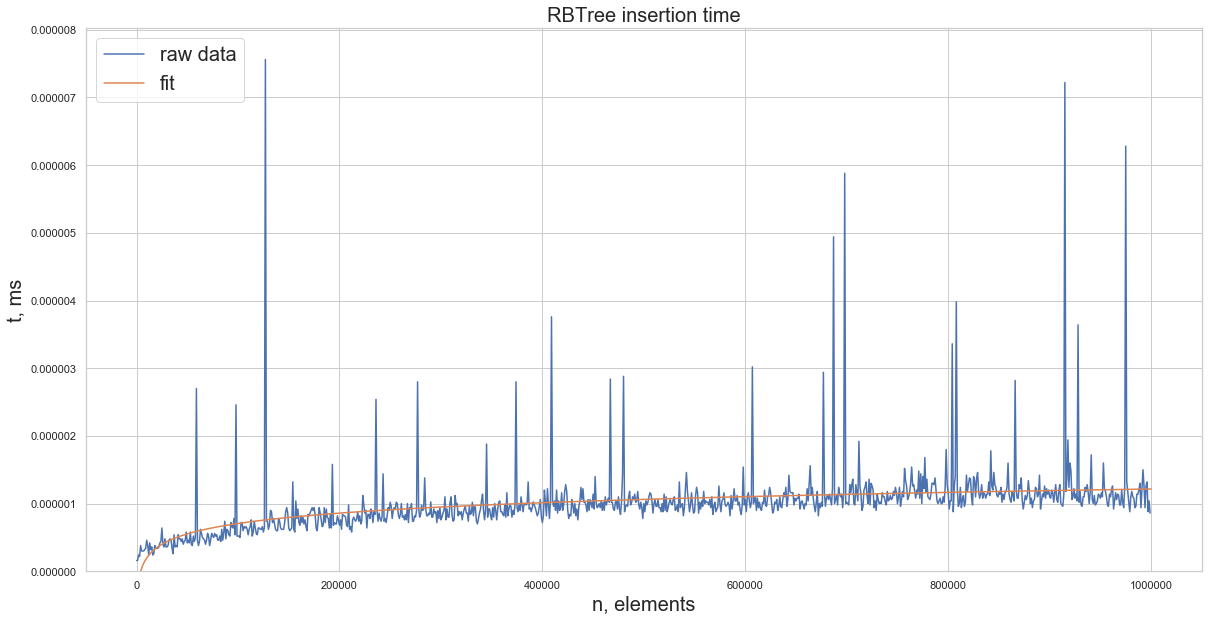

In [54]:
drawGraphs(rb_insert_time, num, "RBTree", "insertion")

### Searching

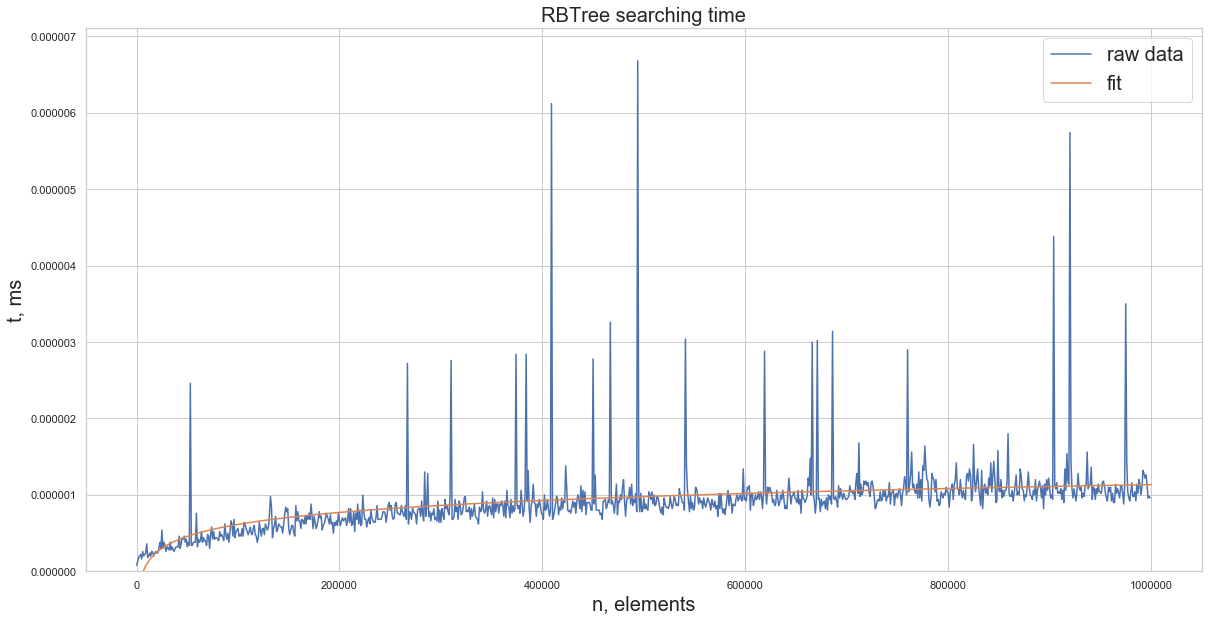

In [55]:
drawGraphs(rb_search_time, num, "RBTree", "searching")

### Deletion

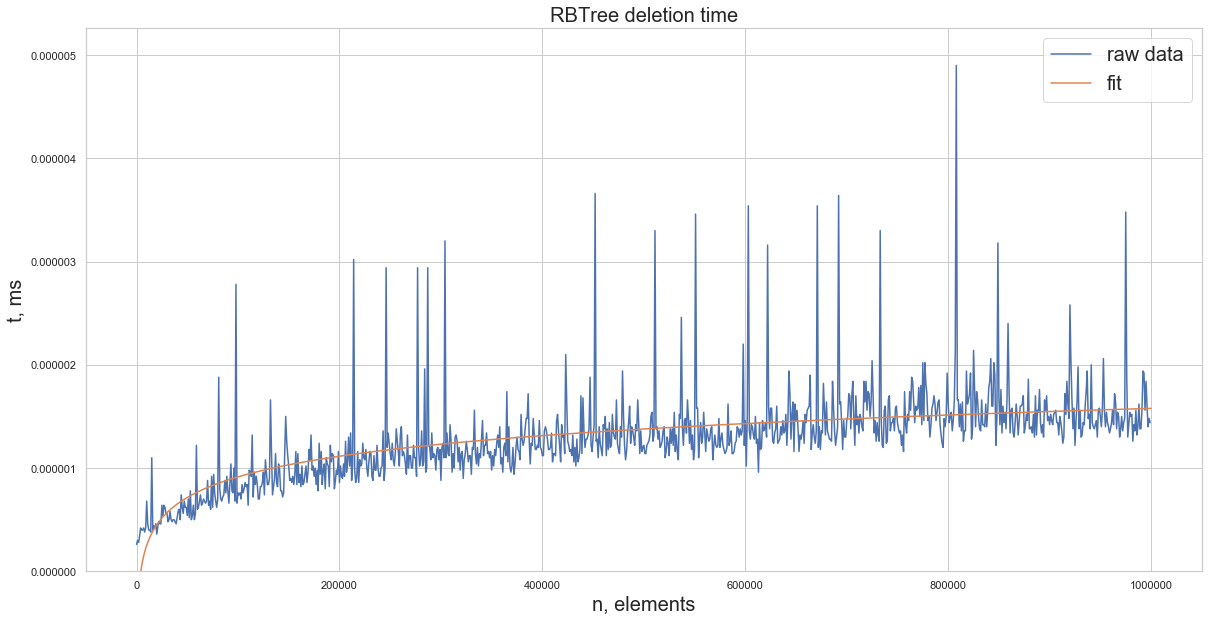

In [56]:
drawGraphs(rb_delete_time, num, "RBTree", "deletion")

# Sorted array

Отсортированныый массив. 

Среднее время вставки O(n) - при каждой вставке не в конец массива приходится его перепаковывать. Возможна реаллокация массива, если при очередной вставке размер превысит ёмкость

Среднее время удаления O(n) - при каждом удалении не из конца массива, его также приходится перепаковывать.

Среднее время поиска O(log(n)) - при реализации бинарного поиска.

In [37]:
sarr_insert_time, sarr_search_time, sarr_delete_time, _ = evaluate(trees.SortedArrInt(), unique_num_set)

Insert, Mean : 0.044135 ms.,  Max 7.533620 ms.
Search, Mean : 0.000243 ms.,  Max 0.230220 ms.
Delete, Mean : 0.119639 ms.,  Max 5.422740 ms.
Total time 1715.281241, sec


### Insertion

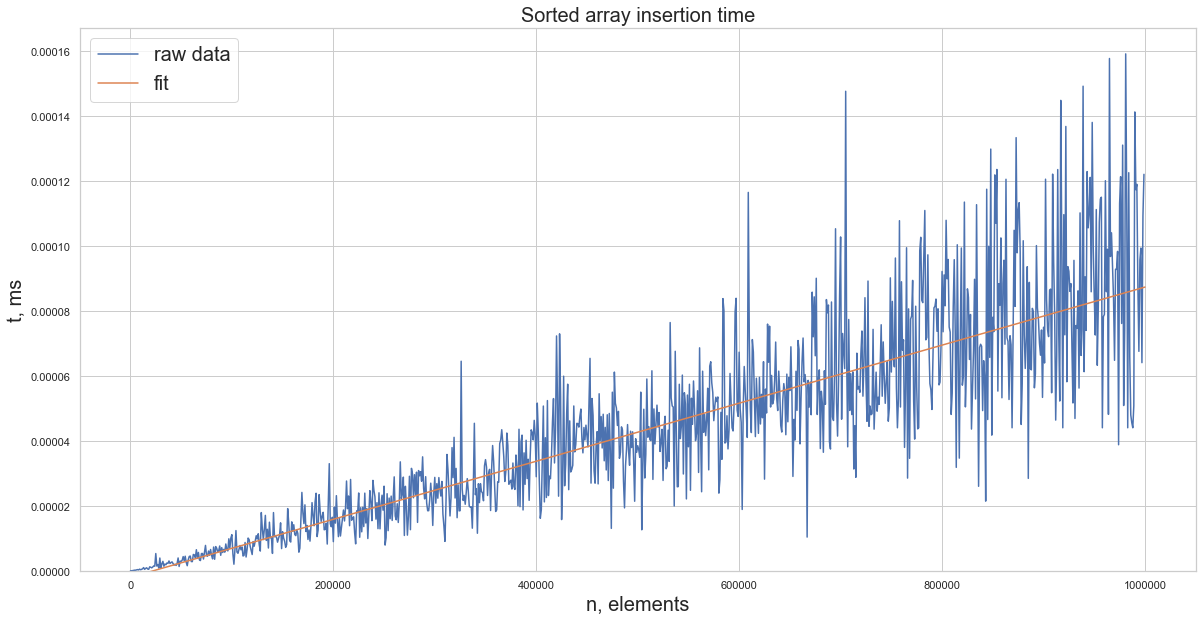

In [38]:
drawGraphs(sarr_insert_time, num, "Sorted array", "insertion")

### Searching

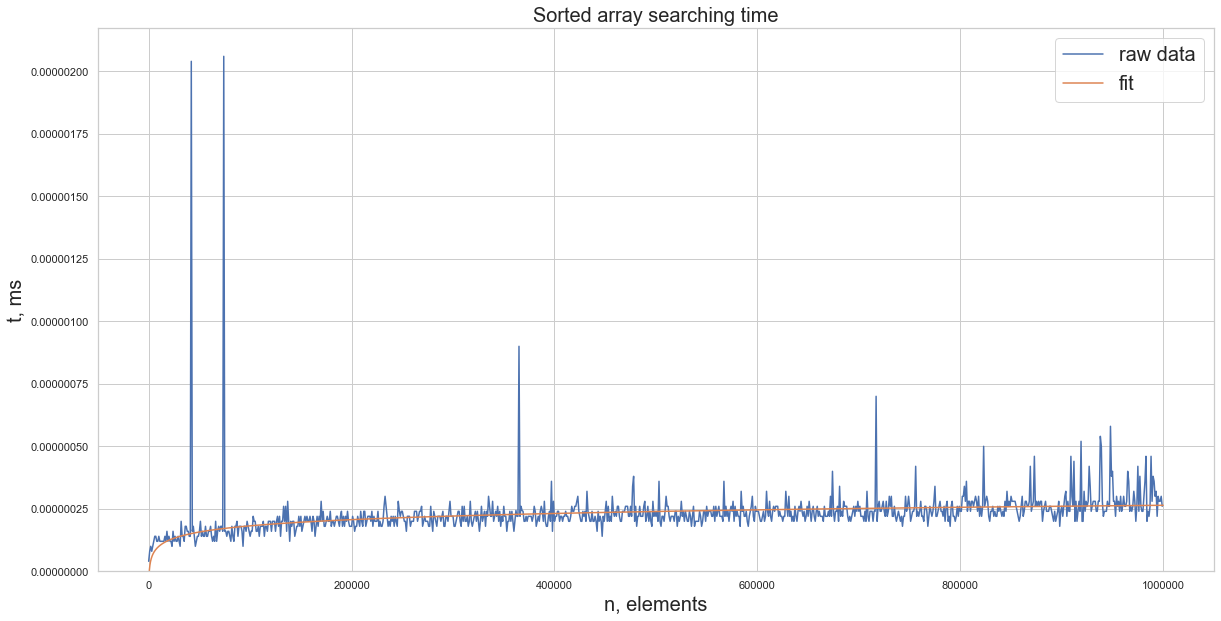

In [66]:
drawGraphs(sarr_search_time, num, "Sorted array", "searching")

### Deletion

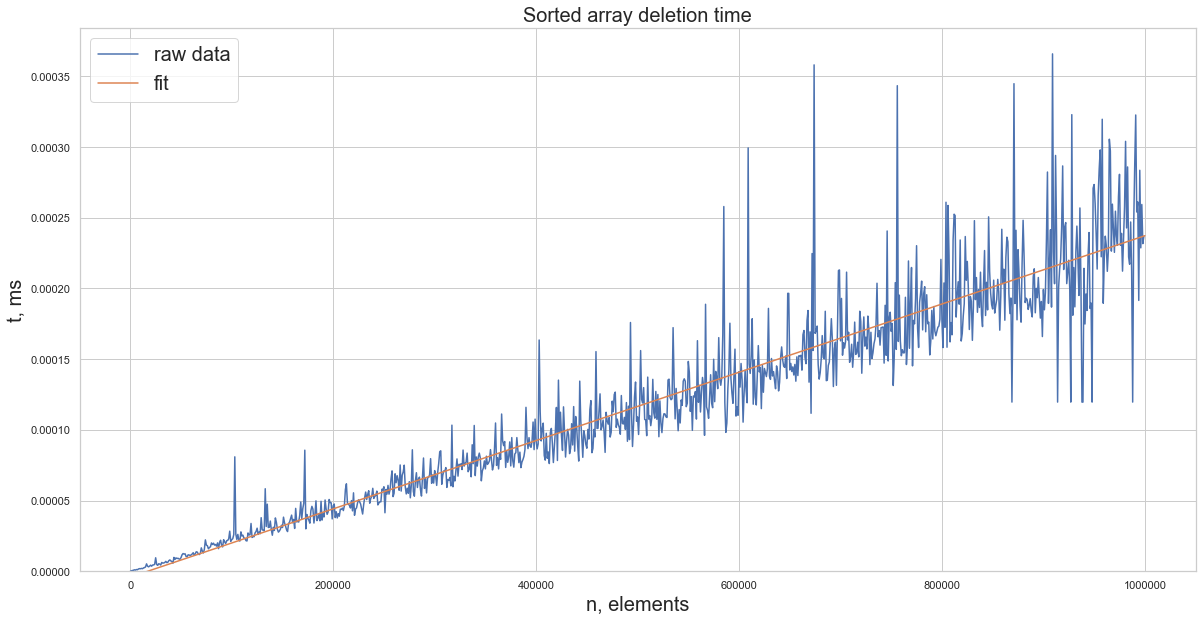

In [40]:
drawGraphs(sarr_delete_time, num, "Sorted array", "deletion")

# Сравнение

In [108]:
def drawAllGraphs(times, num, name, op_name, density):
    # Выбираем контрольные значения для оси X    # 
    x = [i*density for i in range(len(unique_num_set)//density)]
    x[-1] += -1
    
    plt.title(f"{name} {op_name} time", fontsize=20)
    plt.xlabel('n, elements', fontsize=20)
    plt.ylabel('t, ms', fontsize=20)
    for t in times:
        y = [t[el] for el in x]
        plt.plot(x, y) 
    plt.legend(['Splay', 'AVL', 'Treap', 'RB', "Sorted arr"], fontsize=20)
    plt.ylim(bottom=0., top=max(times[-len(times)]))

def drawApproximationGraphs(times, num, name, op_name):
    plt.title(f"{name} {op_name} time", fontsize=20)
    plt.xlabel('n, elements', fontsize=20)
    plt.ylabel('t, ms', fontsize=20)
    
    i = 0
    for t in times:
        repeat = True
        while repeat:
            try:
                if(i != len(times) - 1 or  op_name == 'searching'):
                    coeff = np.polyfit(np.log2(num), t, 1)
                    y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
                else:
                    coeff = np.polyfit(num, t, 1)
                    y = [n*coeff[0] + coeff[1] for n in num]
                repeat = False
                plt.plot(num, y)  
            except Exception:
                pass
        i+=1

    plt.legend(['Splay', 'AVL', 'Treap', 'RB', "Sorted arr"],  fontsize=20)
    plt.ylim(bottom=0., top=max(times[-len(times)]))
    pass

## Вставка

### Каждое 1000 значение

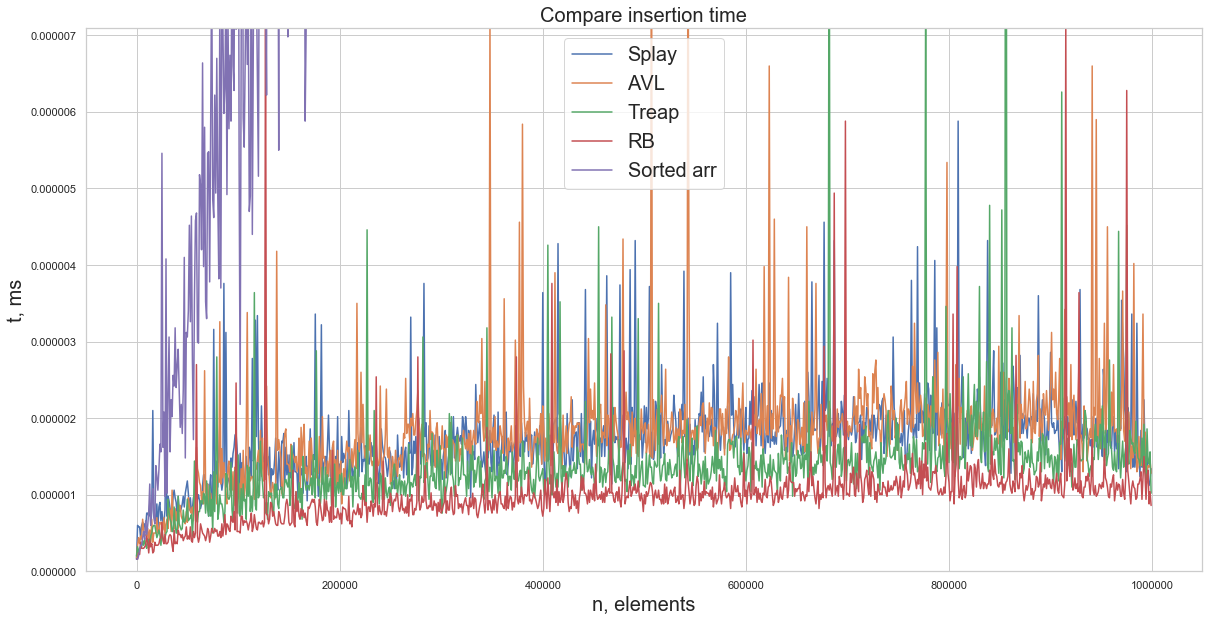

In [109]:
drawAllGraphs([sp_insert_time, avl_insert_time, treap_insert_time, rb_insert_time, sarr_insert_time],
              num, "Compare", "insertion",10**3)

### Каждое 10000 значение

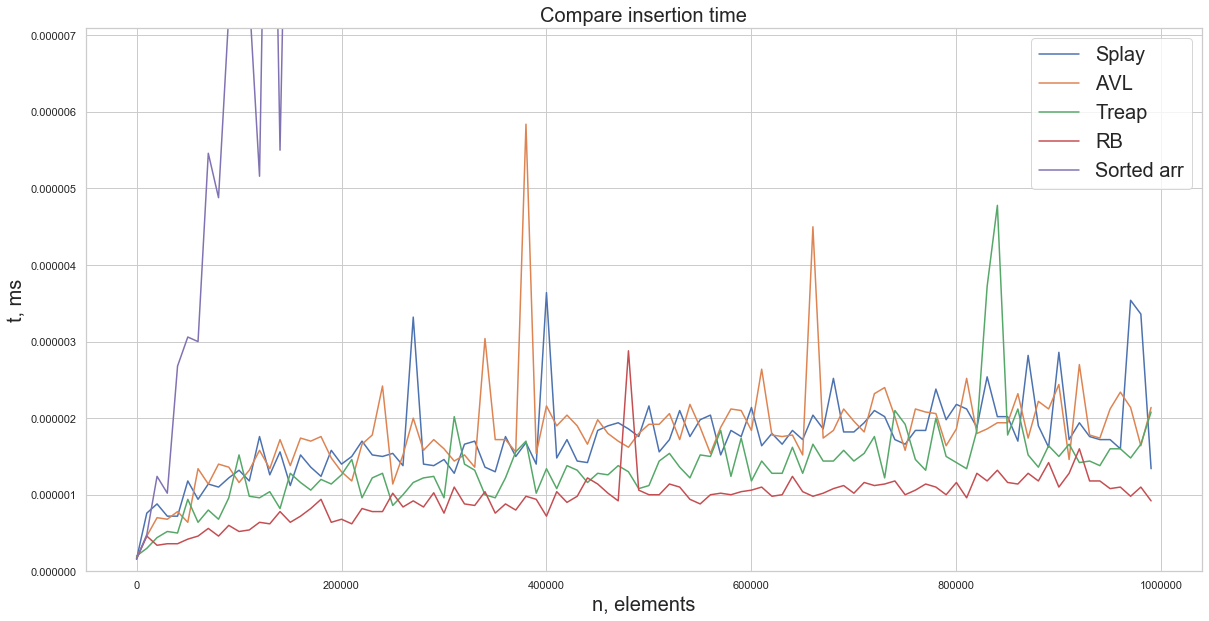

In [110]:
# Рисуем каждое 10000 значение
drawAllGraphs([sp_insert_time, avl_insert_time, treap_insert_time, rb_insert_time, sarr_insert_time],
              num, "Compare", "insertion",10**4)

### Каждое 100000 значение

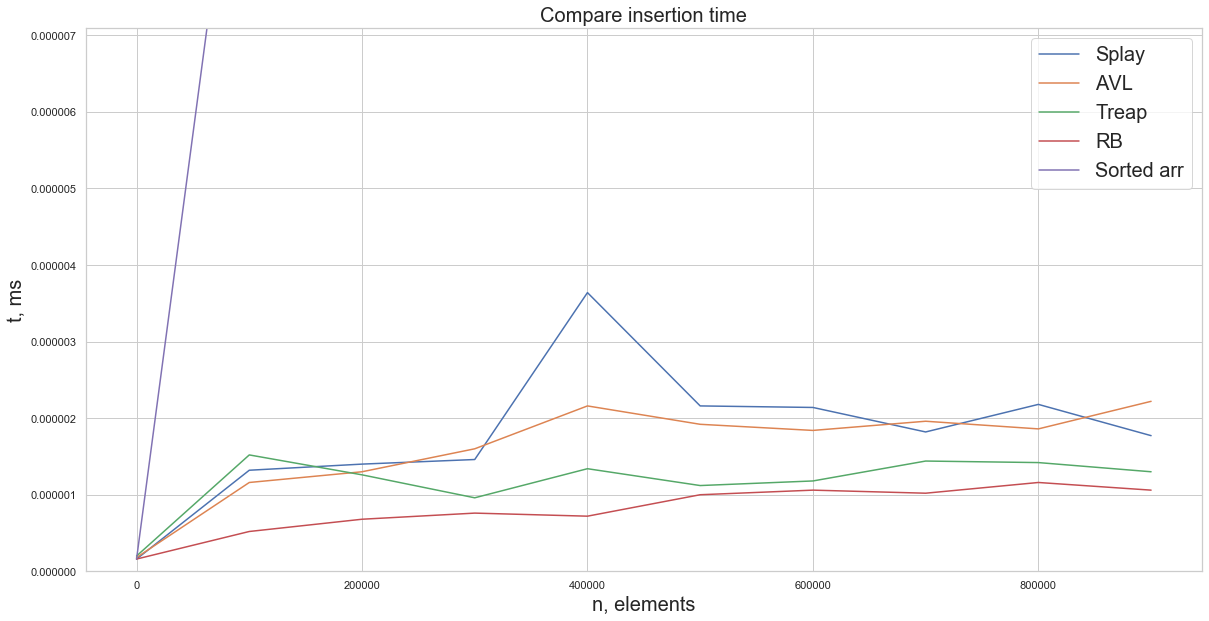

In [111]:
# Рисуем каждое 100000 значение
drawAllGraphs([sp_insert_time, avl_insert_time, treap_insert_time, rb_insert_time, sarr_insert_time],
              num, "Compare", "insertion",10**5)

### Аппроксимация функциями 

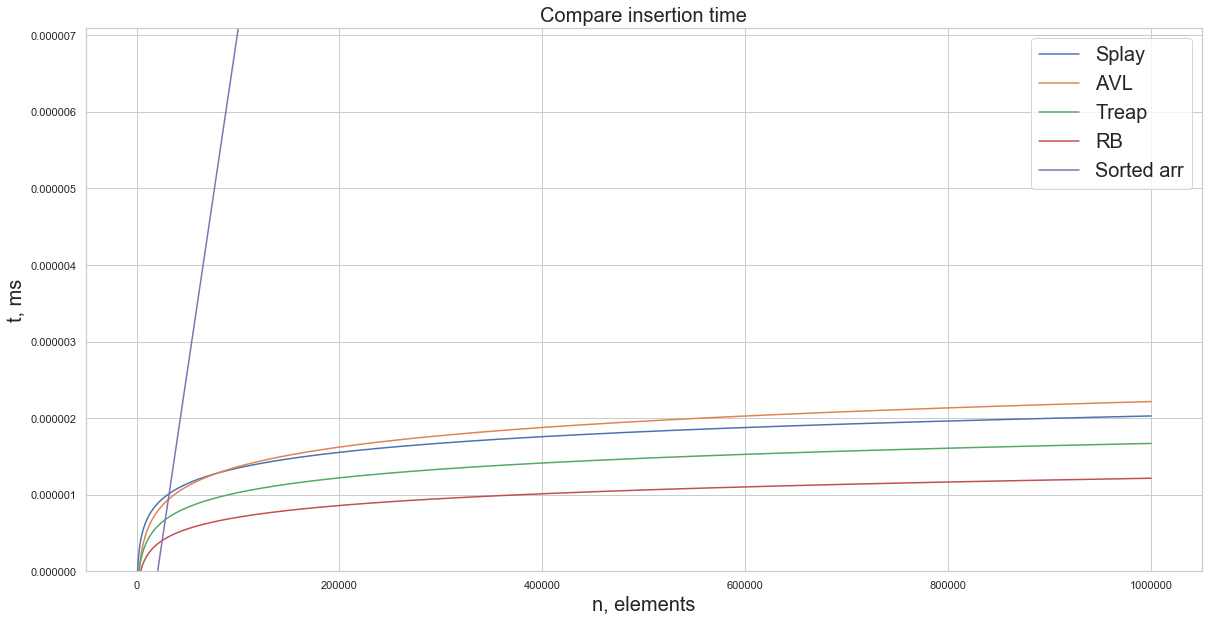

In [112]:
drawApproximationGraphs([sp_insert_time, avl_insert_time, treap_insert_time, rb_insert_time, sarr_insert_time],
              num, "Compare", "insertion")

## Удаление

### Каждое 1000 значение

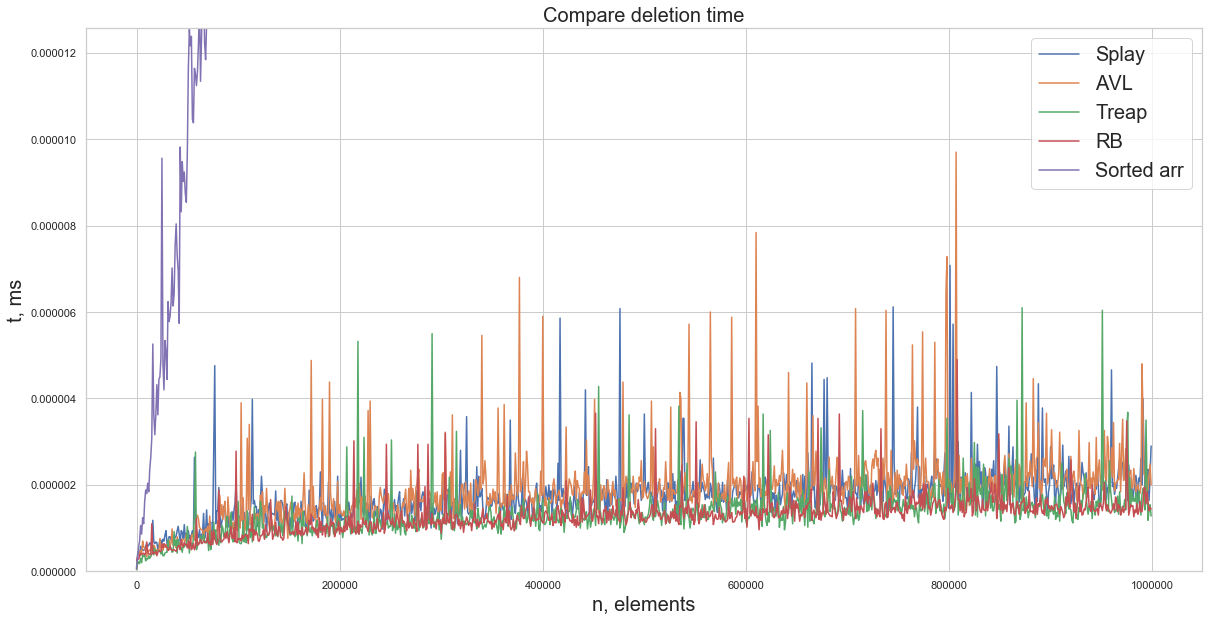

In [113]:
drawAllGraphs([sp_delete_time, avl_delete_time, treap_delete_time, rb_delete_time, sarr_delete_time],
              num, "Compare", "deletion", 10**3)

### Каждое 10000 значение

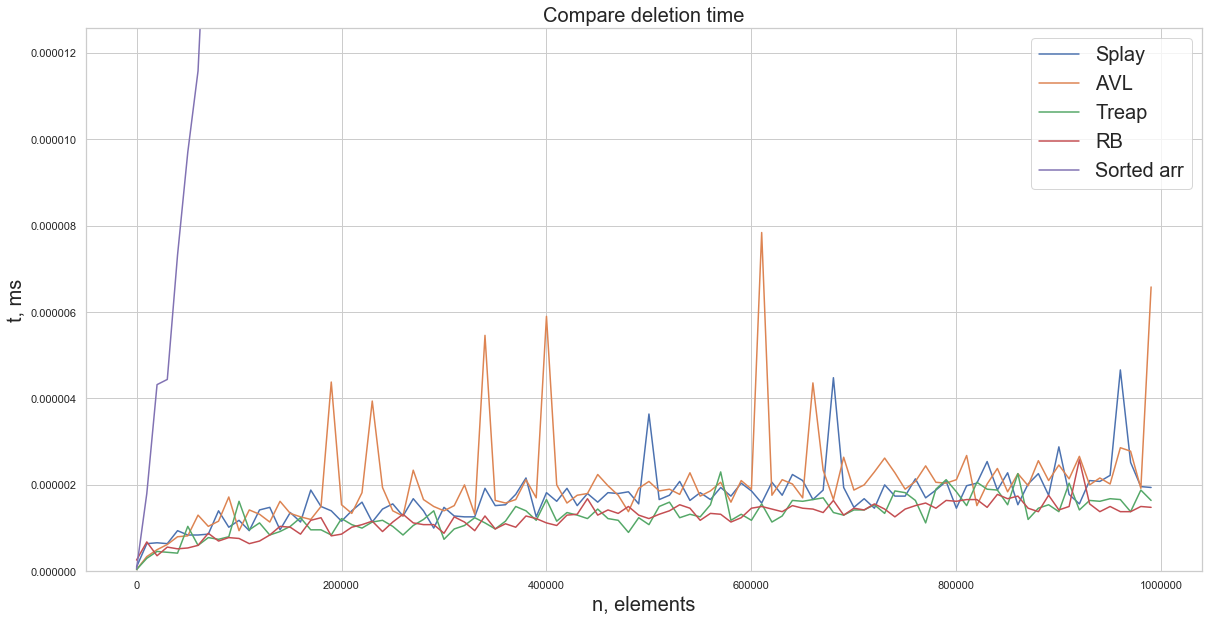

In [114]:
drawAllGraphs([sp_delete_time, avl_delete_time, treap_delete_time, rb_delete_time, sarr_delete_time],
              num, "Compare", "deletion", 10**4)

### Каждое 100000 значение

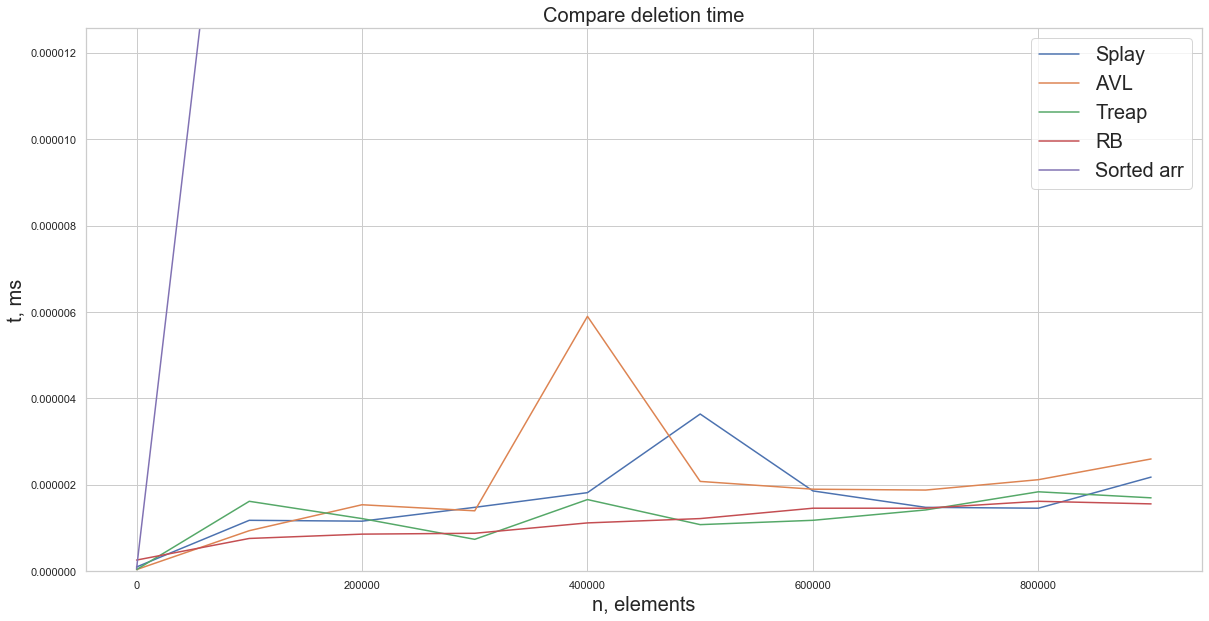

In [115]:
drawAllGraphs([sp_delete_time, avl_delete_time, treap_delete_time, rb_delete_time, sarr_delete_time],
              num, "Compare", "deletion", 10**5)

### Аппроксимация функциями 

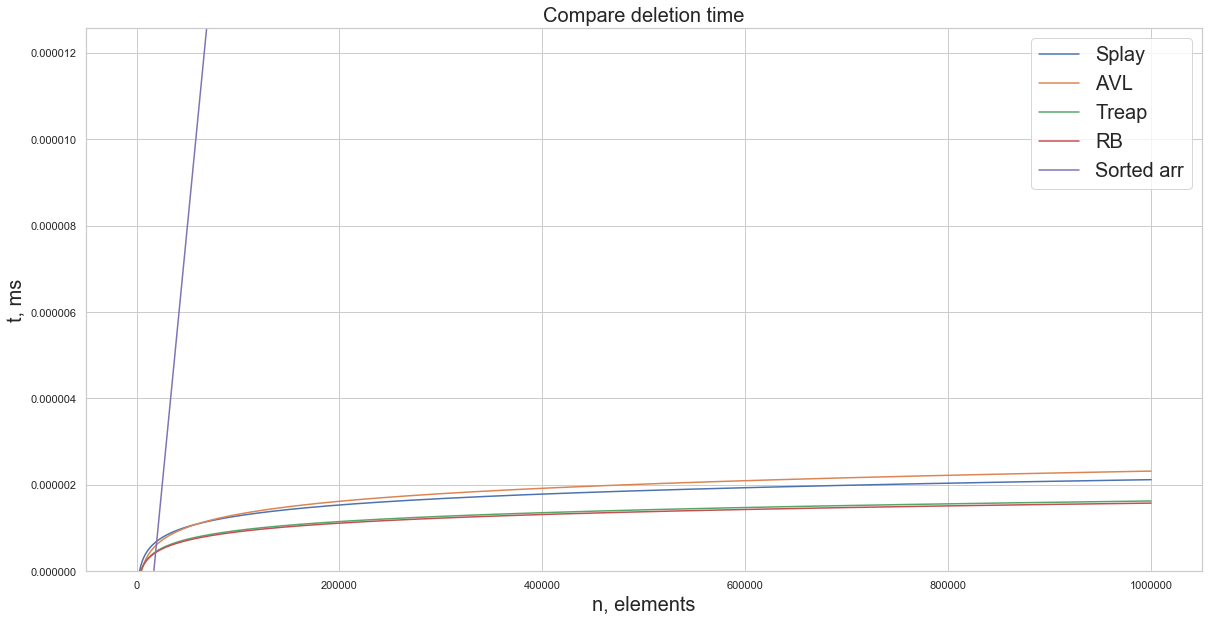

In [117]:
drawApproximationGraphs([sp_delete_time, avl_delete_time, treap_delete_time, rb_delete_time, sarr_delete_time],
              num, "Compare", "deletion")

## Поиск

### Каждое 1000 значение

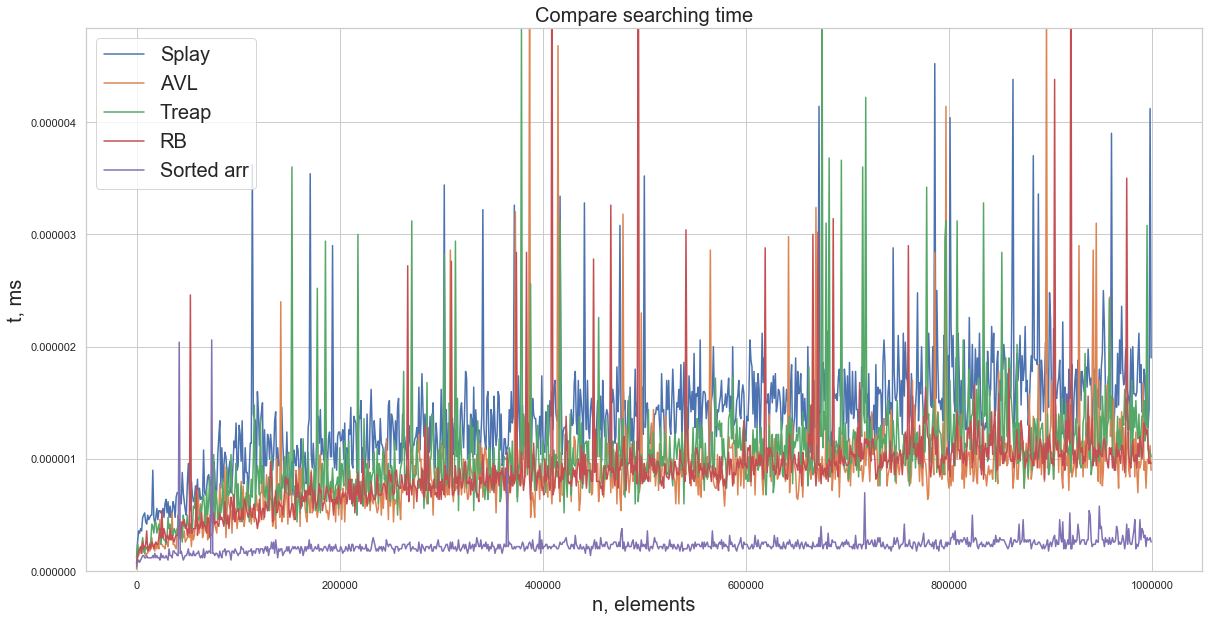

In [118]:
drawAllGraphs([sp_search_time, avl_search_time, treap_search_time, rb_search_time, sarr_search_time],
              num, "Compare", "searching", 10**3)

### Каждое 10000 значение

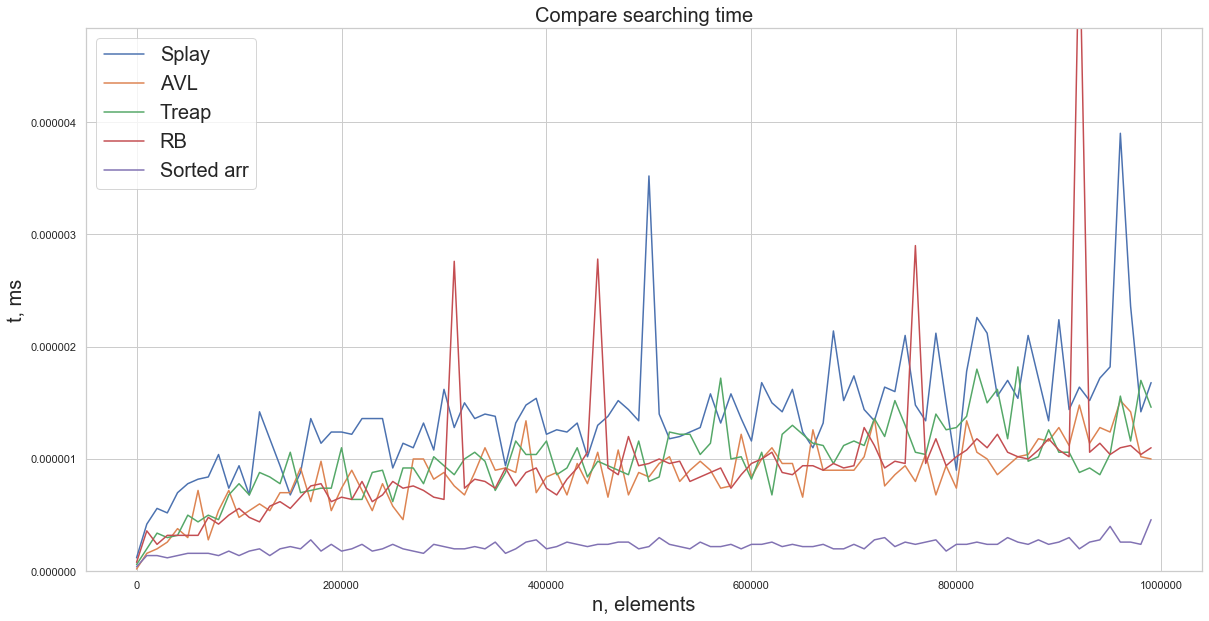

In [119]:
drawAllGraphs([sp_search_time, avl_search_time, treap_search_time, rb_search_time, sarr_search_time],
              num, "Compare", "searching", 10**4)

### Каждое 100000 значение

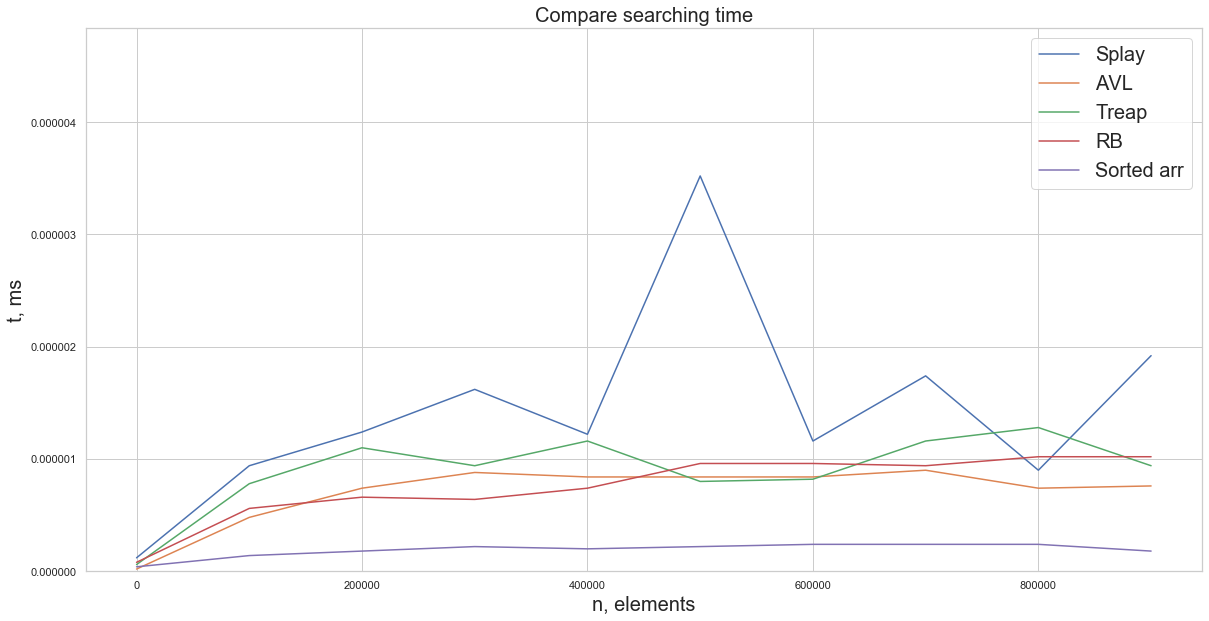

In [120]:
drawAllGraphs([sp_search_time, avl_search_time, treap_search_time, rb_search_time, sarr_search_time],
              num, "Compare", "searching", 10**5)

### Аппроксимация функциями 

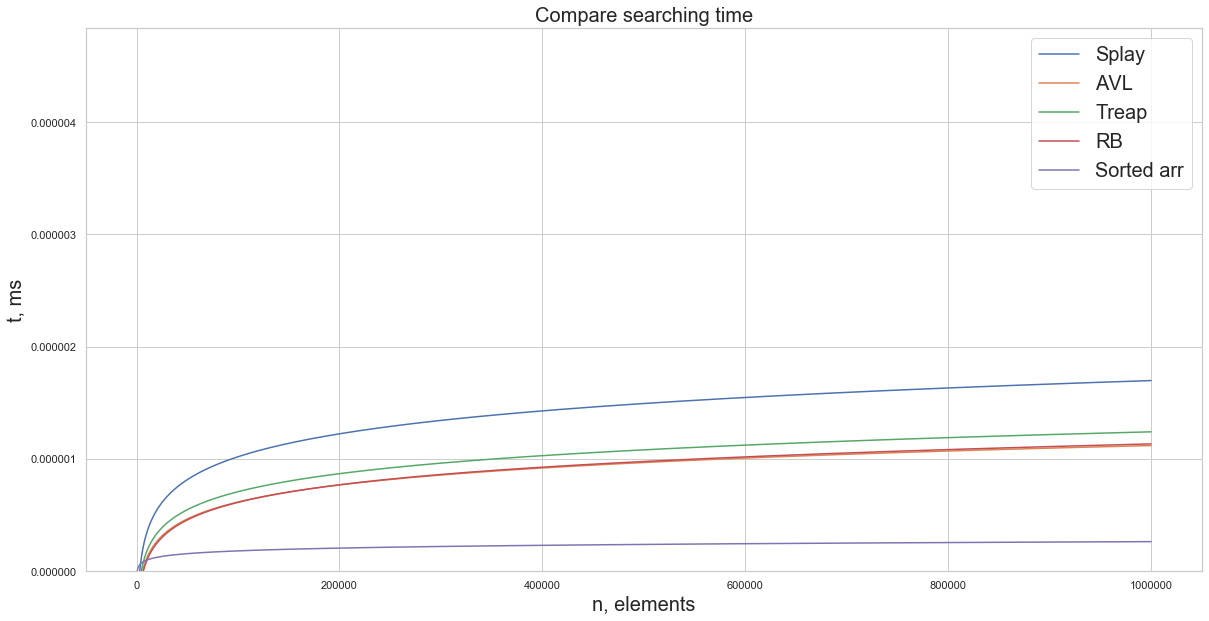

In [122]:
drawApproximationGraphs([sp_search_time, avl_search_time, treap_search_time, rb_search_time, sarr_search_time],
              num, "Compare", "searching")